In [1]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import seaborn as sns
import copy, time, matplotlib, sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
from torchsummary import summary

import torchvision
import torchvision.transforms as T

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
# plt.rcParams.update({'font.size':11})

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Regularization

In [ ]:
''' Why regularize?

* Regularizatioon
- Penalizes "memorization" (over-learning examples).
- Helps the model generalize to unseen examples.
- Changes the representations of learning (either more sparse or more distributed depending on the regularizer).

* Other observations
- Can increase or decrease training time.
- Can decrease training accuracy but increase generalization.
- Works better for large models with multiple hidden layers.
- Generally works better with sufficient data.
'''

In [ ]:
''' Three families of regularizers (in DL)

1) Node regularization: Modify the model (dropout).
2) Loss regularization: Add a cost to the loss function (L1/2).
3) Data regularization: Modify or add data (batch training, data augmentation, normalization).
'''

In [ ]:
'''
Node regularization
* Dropout: "Remove" nodes randomly during learning (force activation=0).

Loss regularization
* L1/L2 regularization ("weight decay"): Add a cost to the loss function to prevent weights from getting too large.

Data regularization
* Data augmentation: Add more data as slightly modified versions of existing data (usually just for images).
'''

In [ ]:
''' How to think about regularization
- Adds a cost to the complexity of the solution.
- Forces the solution to be smooth.
- Prevents the model from learning item-specific details. (focus more on general patterns of data)

Which regularization method to use?
- Some general guidelines for when to use which method.
- Oftentimes the "best" method is problem- or architecture-specific.
- In many cases, different regularization methods work equally well.
'''

# train() and eval() modes

In [ ]:
''' Training vs. evaluation mode
- Gradients are computed only during backprop, not during evaluation.
- Some regularization methods are applied only during training, not during evaluation.
=> Ergo: We need a way to deactivate gradient computations and regularization while evaluating model performance.

net.train()
- Training mode
- Regularization active
- Necessary for training regularization, on by default.

net.eval()
- Testing mode
- Regularization off
- Necessary when evaluating models with regularization.

torch.no_grad()
- Used in testing mode
- Gradients not computed
- Never necessary, makes large models evaluate faster.
'''

# Dropout regularization

In [ ]:
''' Dropout regularization: how it works
- Dropout reduces the overall activation (fewer elements in the weighted sums).
- Solutions:
1) Scale up the weights during training.
2) Scale down the weights during testing.

what it does
* Effects
- Prevents a single node from learning too much.
- Forces the model to have distributed representations.
- Makes the model less reliant on individual nodes and thus more stable.

Other observations
- Generally requires more training (though each epoch computes faster).
- Can decrease training accuracy but increase generalization.
- Usually works better on deep than shallow networks.
- Debate about applying it to convolution layers.
- Works better with sufficient data, unnecessary with "enough" data.
'''

## Using dropout

In [ ]:
# define a dropout instance and make some data
prob = .25

dropout = nn.Dropout(p=prob)
x = torch.ones(10)

# let's see what dropout returns
y = dropout(x)
print(y)
print(torch.mean(y))

tensor([0.0000, 0.0000, 1.3333, 1.3333, 0.0000, 1.3333, 1.3333, 0.0000, 0.0000,
        1.3333])
tensor(0.6667)


In [ ]:
print(y * (1-prob))

tensor([0., 0., 1., 1., 0., 1., 1., 0., 0., 1.])


In [ ]:
# dropout is turned off when evaluating the model
dropout.eval()
y = dropout(x)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [ ]:
# annoyingly, F.dropout() is not deactivated in eval mode:

dropout.eval()
y = F.dropout(x)
print(y)
print(torch.mean(y))

tensor([0., 2., 2., 0., 2., 0., 0., 2., 2., 2.])
tensor(1.2000)


In [ ]:
# but you can manually switch it off
y = F.dropout(x, training=False)

print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [ ]:
# the model needs to be reset after toggling into eval mode
dropout.train()
y = dropout(x)
print(y) # with dropout

dropout.eval()
y = dropout(x)
print(y) # without dropout

# dropout.train()
y = dropout(x)
print(y) # still w/o dropout ;)

dropout.train()
y = dropout(x)
print(y)

tensor([1.3333, 0.0000, 1.3333, 1.3333, 0.0000, 0.0000, 1.3333, 1.3333, 1.3333,
        1.3333])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1.3333, 1.3333, 1.3333, 0.0000, 1.3333, 0.0000, 1.3333, 1.3333, 1.3333,
        1.3333])


# Dropout regularization in practice

## Create the data

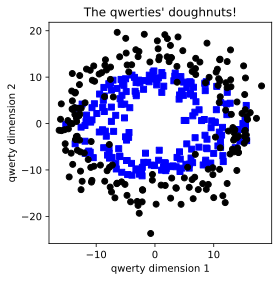

In [ ]:
# create data
nPerClust = 200

th = np.linspace(0,4*np.pi, nPerClust)
r1 = 10
r2 = 15

# generate data
a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3,
        r1*np.sin(th) + np.random.randn(nPerClust) ]
b = [ r2*np.cos(th) + np.random.randn(nPerClust),
        r2*np.sin(th) + np.random.randn(nPerClust)*3 ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust, 1)), np.ones((nPerClust, 1))))

# concatenate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(4,4))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bs')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ko')
plt.title("The qwerties' doughnuts!")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

## Seperate the data into DataLoaders

In [ ]:
# split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)

# convert into PyTorch Datasets
trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

# translate into dataloader objects
batchsize = 16
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## Create the model

In [ ]:
class theModelClass(nn.Module):
    def __init__(self, dropoutRate):
        super().__init__()

        # layers
        self.input = nn.Linear(2,128)
        self.hidden = nn.Linear(128,128)
        self.output = nn.Linear(128,1)

        # parameters
        self.dr = dropoutRate

    # forward pass
    def forward(self, x):

        # pass the data through the input layer
        x = F.relu(self.input(x))

        # dropout after input layer
        x = F.dropout(x, p=self.dr, training=self.training) # training=self.training means to turn off during eval mode

        # pass the data through the hidden layer
        x = F.relu(self.hidden(x))

        # dropout after hidden layer
        x = F.dropout(x, p=self.dr, training=self.training) # training=self.training means to turn off during eval mode

        # output layer
        x = self.output(x)
        # no dropout here!!
        return x

In [ ]:
# test the model
tmpnet = theModelClass(.25)

# run some random data through
tmpdata = torch.randn((10,2))
yhat = tmpnet(tmpdata)
yhat

tensor([[-0.1260],
        [-0.0623],
        [ 0.0779],
        [ 0.2235],
        [ 0.0759],
        [ 0.0575],
        [ 0.1929],
        [ 0.1540],
        [ 0.0040],
        [ 0.0978]], grad_fn=<AddmmBackward0>)

## Functions to create and train the net

In [ ]:
def createANewModel(dropoutrate):

    # grab an instance of the model class
    ANNQC = theModelClass(dropoutrate)

    # loss function
    lossfunc = nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNQC.parameters(), lr=.002)

    return ANNQC, lossfunc, optimizer

In [ ]:
# train the model

# training parameter
numepochs = 1000

def trainTheModel(ANNQC, lossfunc, optimizer):

    # initialize accuracies as empties
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # switch training mode on
        ANNQC.train()

        # loop over training data batches
        batchAcc = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = ANNQC(X)
            loss = lossfunc(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append( 100 * torch.mean(((yHat>0)==y).float()).item() )
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # test accuracy
        ANNQC.eval() # switch training off
        X, y = next(iter(test_loader))
        yHat = ANNQC(X)
        testAcc.append( 100 * torch.mean(((yHat>0)==y).float()).item() )

    # function output
    return trainAcc, testAcc

## Test the model

In [ ]:
# create a model
dropoutrate = .0
ANNQC, lossfunc, optimizer = createANewModel(dropoutrate)

# train the model
trainAcc, testAcc = trainTheModel(ANNQC, lossfunc, optimizer)

In [ ]:
# create 1D smoothing filter
def smooth(x, k=5):
    return np.convolve(x, np.ones(k)/k, mode='same')

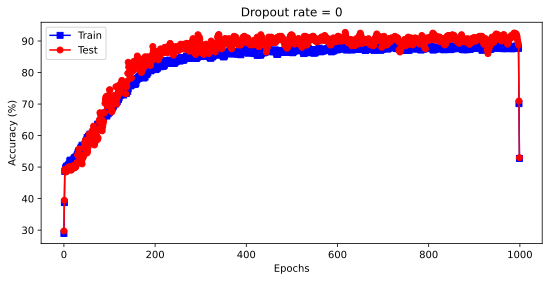

In [ ]:
# plot the results
fig = plt.figure(figsize=(9,4))

plt.plot(smooth(trainAcc), 'bs-')
plt.plot(smooth(testAcc), 'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train', 'Test'])
plt.title('Dropout rate = %g' %dropoutrate)

plt.show()

## Now for the experiment!

In [ ]:
dropoutRates = np.arange(10)/10
dropoutRates

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [ ]:
results = np.zeros((len(dropoutRates), 2))

for di in range(len(dropoutRates)):

    # create and train the model
    ANNQC, lossfunc, optimizer = createANewModel(dropoutRates[di])
    trainAcc, testAcc = trainTheModel(ANNQC, lossfunc, optimizer)

    # store accuracies from last 100 epochs
    results[di, 0] = np.mean(trainAcc[-100:])
    results[di, 1] = np.mean(testAcc[-100:])

In [ ]:
# plot the experiment results
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(dropoutRates, results, 'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train', 'Test'])

ax[1].plot(dropoutRates, -np.diff(results, axis=1), 'o-')
ax[1].plot([0,.9],[0,0], 'k--')
ax[1].set_xlabel('Droppout proportion')
ax[1].set_ylabel('Train-test difference (acc %)')

plt.show()

# Dropout example 2

In [ ]:
iris = sns.load_dataset('iris', cache=False)

data = torch.tensor(iris[iris.columns[:4]].values).float()

labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

## Separate the data into DataLoaders

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)

trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

batchsize = 16
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## Create the model and a training regimen

In [ ]:
class theModelClass(nn.Module):
    def __init__(self, dropoutRate):
        super().__init__()

        # layers
        self.input = nn.Linear(4,12)
        self.hidden = nn.Linear(12,12)
        self.output = nn.Linear(12,3)

        # parameters
        self.dr = dropoutRate

    # forward pass
    def forward(self, x):

        # input
        x = F.relu( self.input(x) )
        x = F.dropout(x, p=self.dr, training=self.training) # switch dropout off during .eval()

        # hidden
        x = F.relu( self.hidden(x) )
        x = F.dropout(x, p=self.dr, training=self.training)

        # output
        x = self.output(x)
        return x

In [ ]:
# test the model
tmpnet = theModelClass(.25)

# run some random data through
tmpdata = torch.randn((10,4))
yhat = tmpnet(tmpdata)
yhat

tensor([[ 0.3632, -0.1138,  0.2873],
        [ 0.3526,  0.3662,  0.0674],
        [ 0.1983, -0.2345,  0.1532],
        [ 0.4913,  0.2458,  0.0563],
        [ 0.4623,  0.0798,  0.1105],
        [ 0.4686, -0.0911,  0.1049],
        [ 0.5650,  0.2501,  0.1486],
        [ 0.3474,  0.1340,  0.2469],
        [ 0.4873, -0.3012,  0.2633],
        [ 0.3814, -0.2713,  0.1817]], grad_fn=<AddmmBackward0>)

In [ ]:
# a function that creates the ANN model

def createANewModel(dropoutrate):

    # grab an instance of the model class
    ANNiris = theModelClass(dropoutrate)

    # loss function
    lossfunc = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=.005)

    return ANNiris, lossfunc, optimizer

In [ ]:
# train the model

# global parameter
numepochs = 500

def trainTheModel(ANNiris, lossfunc, optimizer):

    # initialize accuracies as empties
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # switch learning on
        ANNiris.train()

        # loop over training data batches
        batchAcc = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = ANNiris(X)
            loss = lossfunc(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # test accuracy
        ANNiris.eval()
        X, y = next(iter(test_loader))
        predlabels = torch.argmax(ANNiris(X), axis=1)
        testAcc.append( 100 * torch.mean((predlabels==y).float()).item() )

    # function output
    return trainAcc, testAcc

## Now for the real work! ;)

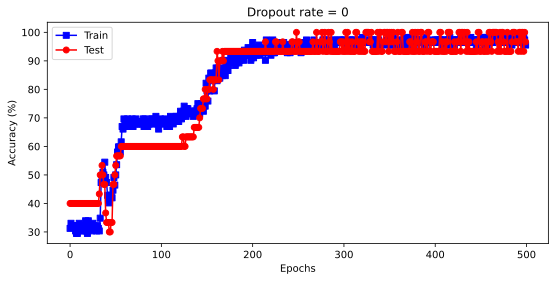

In [ ]:
# create a model
dropoutrate = .0
ANNiris, lossfunc, optimizer = createANewModel(dropoutrate)

# train the model
trainAcc, testAcc = trainTheModel(ANNiris, lossfunc, optimizer)

# plot the results
fig = plt.figure(figsize=(9,4))

plt.plot(trainAcc, 'bs-')
plt.plot(testAcc, 'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train', 'Test'])
plt.title('Dropout rate = %g' %dropoutrate)
plt.show()

In [ ]:
# run an experiment

dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates), 2))

for di in range(len(dropoutRates)):

    # create and train the model
    ANNiris, lossfunc, optimizer = createANewModel(dropoutRates[di])
    trainAcc, testAcc = trainTheModel(ANNiris, lossfunc, optimizer)

    # store accuracies
    results[di, 0] = np.mean(trainAcc[-50:])
    results[di, 1] = np.mean(testAcc[-50:])

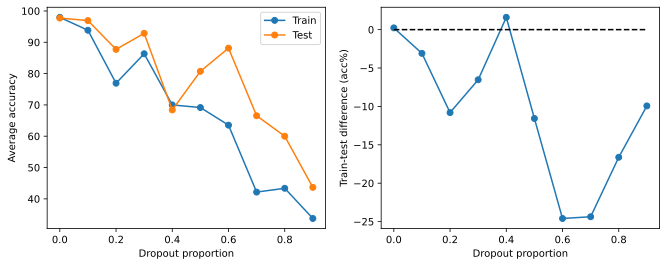

In [ ]:
# plot the experiment results
fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(dropoutRates, results, 'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates, -np.diff(results,axis=1), 'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

# Weight regularization (L1/L2)

In [ ]:
''' What to regularize for?
- L2 regularization ("ridge" or "weight decay") : Shrinks all weights, especially large weights.
- L1 regularization ("lasso") : Creates sparse weights by setting some to 0.

What else to regularize for?
Other possibilities:
- L1+L2 ("elastic net" regression)
- Norm of weight matrix
- Sample-specific (e.g., positive bias on cancer diagnosis)

Why does regularization reduce overfitting?
- Discourages complex and sample-specific representations.
- Prevents overfitting to training examples.
- Large weights lead to instability (very different outputs for similar inputs).

When to use L1/L2 regularization?
- In large, complex models with lots of weights (high risk of overfitting).
- Use L1 when trying to understand the important encoding features (more common in regression than DL).
- When training accuracy is much higher than validation accuracy.
'''

# L2 regularization

In [ ]:
# import dataset
iris = sns.load_dataset('iris', cache=False)

# organize the data
# convert from pandas data frame to tensor
data = torch.tensor(iris[iris.columns[:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

## Break the data into batches

In [ ]:
# split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)

# convert into PyTorch Datasets
trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

# create dataloader objects
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## the model

In [ ]:
# a function that creates the ANN model
def createANewModel(L2lambda):

    # model architecture
    ANNiris = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3),
    )

    # loss function
    lossfunc = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=.005, weight_decay=L2lambda)

    return ANNiris, lossfunc, optimizer

In [ ]:
# train the model

# global parameter
numepochs = 1000

def trainTheModel(ANNiris, lossfunc, optimizer):

    # initialize accuracies as empties
    trainAcc = []
    testAcc = []
    losses = []

    # loop over epochs
    for epochi in range(numepochs):

        ANNiris.train()

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = ANNiris(X)
            loss = lossfunc(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )
            batchLoss.append( loss.item() )
        # end of batch loop...

        # average training accuracy
        trainAcc.append( np.mean(batchAcc) )
        losses.append( np.mean(batchLoss) )

        # test accuracy
        ANNiris.eval()
        X, y = next(iter(test_loader))
        predlabels = torch.argmax( ANNiris(X), axis=1 )
        testAcc.append( 100 * torch.mean((predlabels==y).float()).item() )

    # function output
    return trainAcc, testAcc, losses

In [ ]:
# create a model
L2lambda = .01
ANNiris, lossfunc, optimizer = createANewModel(L2lambda)

# train the model
trainAcc, testAcc, losses = trainTheModel(ANNiris, lossfunc, optimizer)

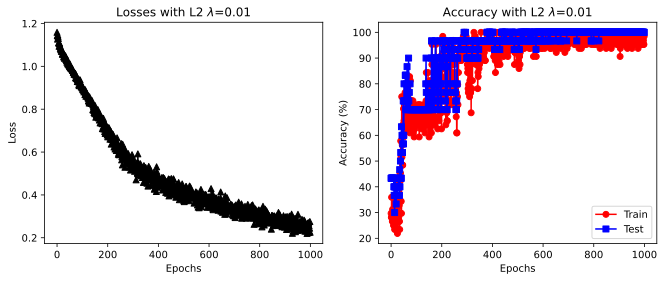

In [ ]:
# plot the results
fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(losses, 'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L2 $\lambda$=' + str(L2lambda))

ax[1].plot(trainAcc, 'ro-')
ax[1].plot(testAcc, 'bs-')
ax[1].set_title('Accuracy with L2 $\lambda$=' + str(L2lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train', 'Test'])

plt.show()

In [ ]:
# create a 1D smoothing filter
def smooth(x,k):
    return np.convolve(x, np.ones(k)/k, mode='same')

## The experiment

In [ ]:
# range of L2 regularization amounts
l2lambdas = np.linspace(0,.1,10)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs, len(l2lambdas)))
accuracyResultsTest = np.zeros((numepochs, len(l2lambdas)))

# loop over L2 amounts
for li in range(len(l2lambdas)):

    # create and train a model
    ANNiris, lossfunc, optimizer = createANewModel(l2lambdas[li])
    trainAcc, testAcc, losses = trainTheModel(ANNiris, lossfunc, optimizer)

    accuracyResultsTrain[:,li] = smooth(trainAcc,10)
    accuracyResultsTest[:,li] = smooth(testAcc,10)

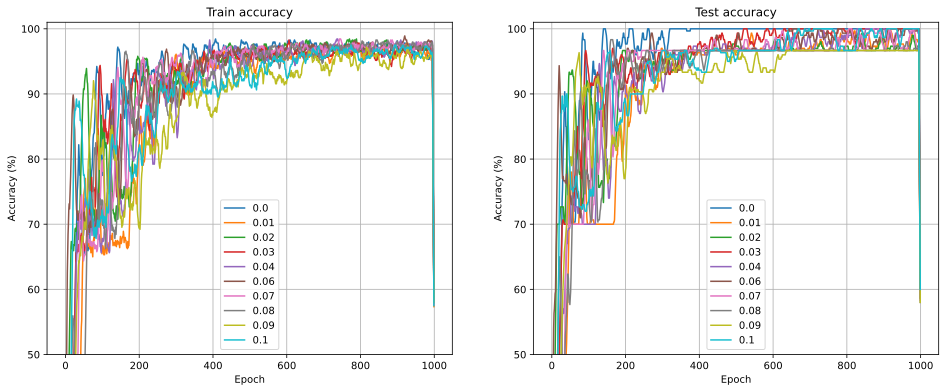

In [ ]:
# plot some results
fig, ax = plt.subplots(1,2, figsize=(16,6))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

leglabels = [np.round(i,2) for i in l2lambdas]

for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,101])
    ax[i].grid()

plt.show()

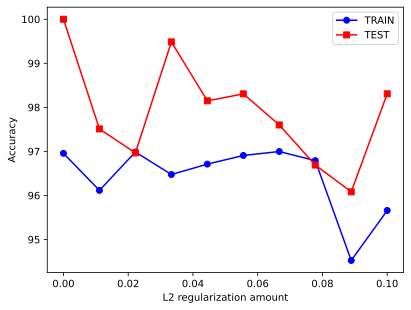

In [ ]:
# show average accuracy by L2 rate

# average only some epochs
epoch_range = [500, 950]

plt.plot(l2lambdas,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(l2lambdas,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L2 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# L1 regularization

In [2]:
# import dataset
iris = sns.load_dataset('iris', cache=False)

# organize the data
# convert from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

## Break the data into batches

In [4]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)

trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(trainset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## Specify the model architecture and training plan

In [5]:
# a function that creates the ANN model
def createANewModel():

    # model architecture
    ANNiris = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3),
    )

    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=.005)

    return ANNiris, lossfunc, optimizer

In [6]:
# explore the model in more detail
tmpmodel = createANewModel()[0]

# print the model architecture
print(tmpmodel)
print()

# print the model's parameters
for i in tmpmodel.named_parameters():
    print(i[0], i[1].shape, i[1].numel())

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)

0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


## Function that trains the model

In [11]:
# train the model

# global parameter
numepochs = 1000

def trainTheModel(L1lambda):

    trainAcc = []
    testAcc = []
    losses = []

    # count the total number of weights in the model
    n_weights = 0
    for pname, weight in ANNiris.named_parameters():
        if 'bias' not in pname:
            n_weights += weight.numel()

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = ANNiris(X)
            loss = lossfunc(yHat, y)

            # add L1 term
            L1_term = torch.tensor(0., requires_grad=True)

            # sum up all abs(weights)
            for pname, weight in ANNiris.named_parameters():
                if 'bias' not in pname:
                    L1_term + torch.sum(torch.abs(weight))

            # add to loss term
            loss += (L1lambda * L1_term / n_weights)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchLoss.append( loss.item() )
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )
        # end of batch loop...

        # get average training accuracy
        trainAcc.append( np.mean(batchAcc) )
        losses.append( np.mean(batchLoss) )

        # test accuracy
        X, y = next(iter(test_loader))
        predlabels = torch.argmax(ANNiris(X), axis=1)
        testAcc.append( 100 * torch.mean((predlabels==y).float()).item() )

    # function output
    return trainAcc, testAcc, losses

## Bring it to life!

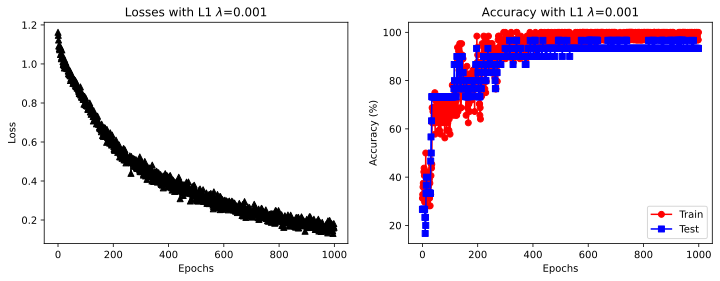

In [14]:
# create a model
ANNiris, lossfunc, optimizer = createANewModel()

# train the model
L1lambda = .001
trainAcc, testAcc, losses = trainTheModel(L1lambda)

# plot the results
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(losses, 'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L1 $\lambda$=' + str(L1lambda))

ax[1].plot(trainAcc, 'ro-')
ax[1].plot(testAcc, 'bs-')
ax[1].set_title('Accuracy with L1 $\lambda$=' + str(L1lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train', 'Test'])

plt.show()

In [13]:
# create a 1D smoothing filter
def smooth(x,k):
    return np.convolve(x, np.ones(k)/k, mode='same')

## Now for the parameteric experiment

In [15]:
# range of L1 regularization amounts
L1lambda = np.linspace(0, .005, 10)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs, len(L1lambda)))
accuracyResultsTest = np.zeros((numepochs, len(L1lambda)))

# loop over L1 amounts
for li in range(len(L1lambda)):

    # create and train a model
    ANNiris, lossfunc, optimizer = createANewModel()
    trainAcc, testAcc, losses = trainTheModel(L1lambda[li])

    # store the results
    accuracyResultsTrain[:,li] = smooth(trainAcc, 10)
    accuracyResultsTest[:,li] = smooth(testAcc, 10)

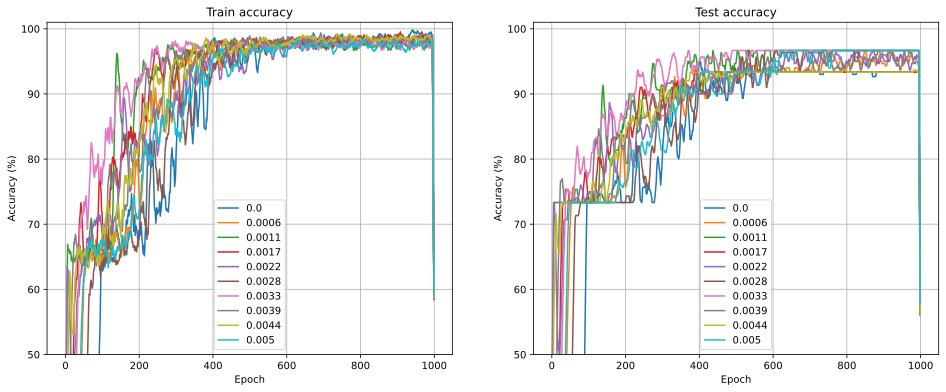

In [16]:
# plot some results
fig, ax = plt.subplots(1,2,figsize=(16,6))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i,4) for i in L1lambda]

# common features
for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,101])
    ax[i].grid()

plt.show()

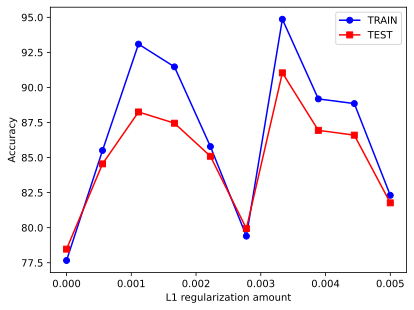

In [18]:
# show average accuracy by L1 rate

# average only some epochs
epoch_range = [160, 360]

plt.plot(L1lambda,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:], axis=0),
         'bo-', label='TRAIN')

plt.plot(L1lambda,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:], axis=0),
         'rs-', label='TEST')

plt.xlabel('L1 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Training in mini-batches

In [ ]:
''' How and why to train with mini-batches?

- Batch size is often powers-of-2 (e.g., 2^4=16), between 2 and 512.
- Training in batches can decrease computation time because of vectorization (matrix multiplication instead of for-loops).
- But batching can increase computation time for large batches and large data samples (e.g., images).
- Batching is a form of regularization:
  It smooths learning by averaging the loss over many samples, and thereby reduces overfitting.
- If samples are highly similar, minibatch=1 can give faster training.

* Mini-batch analogy

- Imagine you take an exam with 100 questions.
- SGD: Teacher gives you detailed feedback on each answer. This is good for learning but very time consuming.
- One batch: Teacher gives you a final exam score with no feedback. Grading is fast, but it's difficult to learn from your mistakes.
- Mini-batch: Teachre gives you a separate grade and feedback on average performance of blocks of 10 questions.
  This balances speed and learning ability.
'''

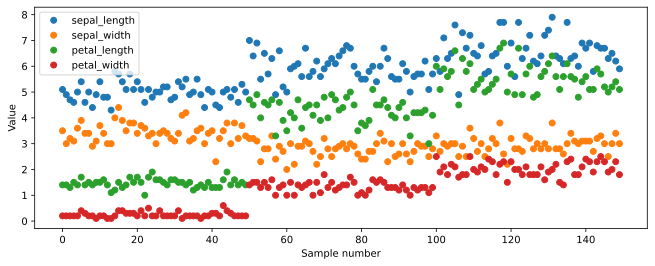

In [19]:
# plot the data
iris.plot(marker='o', linestyle='none', figsize=(11,4))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

## Break the data into batches

In [27]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)

trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

batchsize=4
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

In [28]:
# check sizes of data batches
for X, y in train_loader:
    print(X.shape, y.shape)

torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) torch.Size([4])
torch.Size([4, 4]) t

## Construct the model and training plans

In [29]:
# a function that creates the ANN model
def createANewModel():

    ANNiris = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3),
    )

    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=.0005)

    return ANNiris, lossfunc, optimizer

In [30]:
# train the model

numepochs = 2500

def trainTheModel():

    trainAcc = []
    testAcc = []
    losses = []

    for epochi in range(numepochs):

        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            yHat = ANNiris(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )
            batchLoss.append( loss.item() )

        trainAcc.append( np.mean(batchAcc) )
        losses.append( np.mean(batchLoss) )

        X, y = next(iter(test_loader))
        predlabels = torch.argmax( ANNiris(X), axis=1 )
        testAcc.append( 100 * torch.mean((predlabels==y).float()).item() )

    return trainAcc, testAcc, losses

## Test it out

In [31]:
# create a model
ANNiris, lossfunc, optimizer = createANewModel()

# train the model
trainAcc, testAcc, losses = trainTheModel()

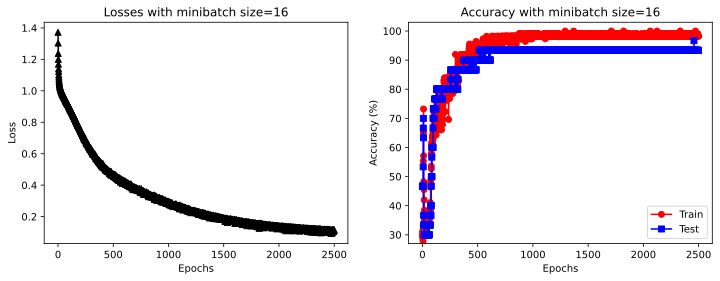

In [26]:
# plot the results
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(losses, 'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with minibatch size=' + str(batchsize))

ax[1].plot(trainAcc, 'ro-')
ax[1].plot(testAcc, 'bs-')
ax[1].set_title('Accuracy with minibatch size=' + str(batchsize))
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epochs')
ax[1].legend(['Train', 'Test'])
ax[1].set_ylim([27,103])

plt.show()

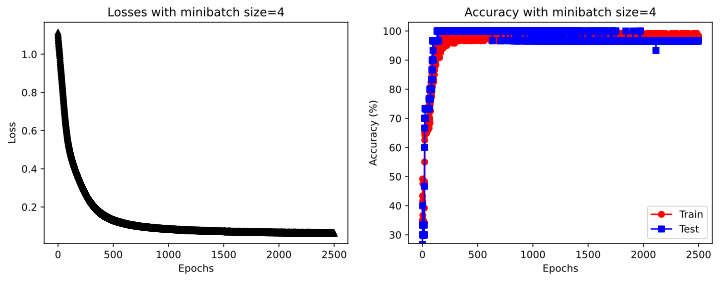

In [32]:
# plot the results
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(losses, 'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with minibatch size=' + str(batchsize))

ax[1].plot(trainAcc, 'ro-')
ax[1].plot(testAcc, 'bs-')
ax[1].set_title('Accuracy with minibatch size=' + str(batchsize))
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epochs')
ax[1].legend(['Train', 'Test'])
ax[1].set_ylim([27,103])

plt.show()

# The importance of equal batch sizes

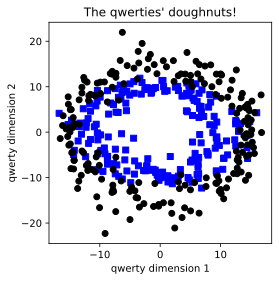

In [33]:
# create data
nPerClust = 200

th = np.linspace(0,4*np.pi, nPerClust)
r1 = 10
r2 = 15

# generate data
a = [ r1*np.cos(th)+np.random.randn(nPerClust)*3,
     r1*np.sin(th)+np.random.randn(nPerClust)]
b = [ r2*np.cos(th)+np.random.randn(nPerClust),
     r2*np.sin(th)+np.random.randn(nPerClust)*3]

# true labels
labels_np = np.vstack((
    np.zeros((nPerClust,1)),
    np.ones((nPerClust,1))
))

# concatenate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(4,4))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bs')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ko')
plt.title("The qwerties' doughnuts!")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

## Seperate the data into DataLoaders

In [36]:
train_data, test_data, train_labels, test_labels = train_test_split(data,labels, test_size=.1)

trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

train_batchsize=16
test_batchsize=testset.tensors[0].shape[0]-2

train_loader = DataLoader(trainset, batch_size=train_batchsize, shuffle=True,drop_last=True)
test_loader = DataLoader(testset, batch_size=test_batchsize)

In [37]:
# check sizes of data batches
for X, y in test_loader:
    print(X.shape, y.shape)

torch.Size([38, 2]) torch.Size([38, 1])
torch.Size([2, 2]) torch.Size([2, 1])


## Model stuff

In [42]:
class theModelClass(nn.Module):
    def __init__(self):
        super().__init__()

        # layers
        self.input = nn.Linear(2,128)
        self.hidden = nn.Linear(128,128)
        self.output = nn.Linear(128,1)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden(x))
        x = self.output(x)
        return x

In [43]:
def createANewModel():

    ANNQC = theModelClass()

    lossfunc = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(ANNQC.parameters(), lr=.01)

    return ANNQC, lossfunc, optimizer

In [44]:
numepochs = 500

def trainTheModel(ANNQC, lossfunc, optimizer):

    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        batchAcc = []
        for X, y in train_loader:

            yHat = ANNQC(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchAcc.append( 100 * torch.mean(((yHat>0)==y).float()).item() )

        trainAcc.append( np.mean(batchAcc) )

        batchAcc = []
        for X, y in test_loader:
            yHat = ANNQC(X)
            batchAcc.append( 100 * torch.mean(((yHat>0)==y).float()).item() )
        testAcc.append( np.mean(batchAcc) )

    return trainAcc, testAcc

## Application

In [45]:
ANNQC, lossfunc, optimizer = createANewModel()
trainAcc, testAcc = trainTheModel(ANNQC, lossfunc, optimizer)

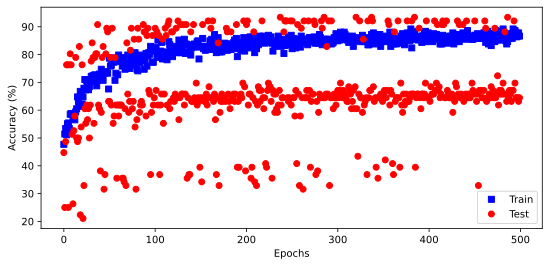

In [46]:
fig = plt.figure(figsize=(9,4))

plt.plot(trainAcc, 'bs')
plt.plot(testAcc, 'ro')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train', 'Test'])

plt.show()

# Effects of mini-batch size

## Things related to data

In [47]:
iris = sns.load_dataset('iris', cache=False)

# organize the data
# convert from pandas data frame to tensor
data = torch.tensor(iris[iris.columns[:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

In [48]:
# split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size=.8)

# convert into PyTorch Datasets
trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

## Things related to the model

In [50]:
# a function that creates the ANN model
def createANewModel():

    # model architecture
    ANNiris = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3),
    )

    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=.001)

    return ANNiris, lossfunc, optimizer

In [54]:
# train the model

numepochs = 500

def trainTheModel():

    trainAcc = []
    testAcc = []
    losses = []

    for epochi in range(numepochs):

        ANNiris.train()

        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            yHat = ANNiris(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )
            batchLoss.append( loss.item() )

        trainAcc.append( np.mean(batchAcc) )
        losses.append( np.mean(batchLoss) )

        ANNiris.eval()

        X, y = next(iter(test_loader))

        with torch.no_grad():
            predlabels = torch.argmax( ANNiris(X), axis=1 )

        testAcc.append( 100 * torch.mean((predlabels==y).float()).item() )

    return trainAcc, testAcc, losses

## Run the experiment and visualize the results

In [55]:
# range of batch sizes
batchsizes = 2**np.arange(1,7)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs, len(batchsizes)))
accuracyResultsTest = np.zeros((numepochs, len(batchsizes)))

# test data doesn't vary by training batch size
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

for bi in range(len(batchsizes)):

    # create dataloader object
    train_loader = DataLoader(trainset, batch_size=int(batchsizes[bi]), shuffle=True, drop_last=True)

    # create and train a model
    ANNiris, lossfunc, optimizer = createANewModel()
    trainAcc, testAcc, _ = trainTheModel()

    # store results
    accuracyResultsTrain[:,bi] = trainAcc
    accuracyResultsTest[:,bi] = testAcc

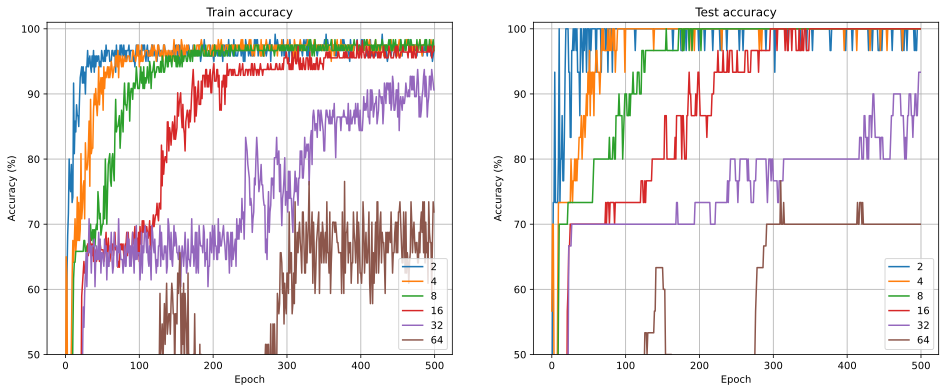

In [56]:
# plot some results
fig, ax = plt.subplots(1,2, figsize=(16,6))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
    ax[i].legend(batchsizes)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,101])
    ax[i].grid()

plt.show()